In [1]:
import pandas as pd
from collections import Counter
from tqdm import tqdm
import re
import pickle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import Normalizer
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier as xgbc
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

# Reading Data

In [2]:
# https://github.com/pandas-dev/pandas/issues/11493
# https://stackoverflow.com/questions/52105659/pandas-read-csv-unexpected-end-of-data-error

project_data = pd.read_csv('train_data.csv', engine='python', error_bad_lines = False)
resource_data = pd.read_csv('resources.csv', engine='python', error_bad_lines = False)

# Combining both DataFrames

In [3]:
# https://stackoverflow.com/questions/41581044/pandas-aggregate-rows-for-a-given-column-and-count-the-number

rd = resource_data.groupby('id').description
rd = rd.agg(dict(description = lambda x:list(x), number='count'))

/Users/swatisharma/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  after removing the cwd from sys.path.


In [4]:
price_qty_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
resource_data = pd.merge(rd, price_qty_data, on='id', how='left')

In [5]:
project_data = pd.merge(project_data, resource_data, on='id', how='left')

In [6]:
print(len(project_data))

109248


In [7]:
# https://stackoverflow.com/a/2582163/4084039
cols = ['Date' if x=='project_submitted_datetime' else x for x in list(project_data.columns)]

# https://stackoverflow.com/a/49702492/4084039
project_data['Date'] = pd.to_datetime(project_data['project_submitted_datetime'])
project_data.drop('project_submitted_datetime', axis = 'columns', inplace=True)
project_data.sort_values(by=['Date'], inplace=True)

# https://stackoverflow.com/a/13148611/4084039
project_data = project_data[cols]

In [8]:
# consider we have text like this "Math & Science, Warmth, Care & Hunger"
# it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
# this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
# if we have the words "The" we are going to replace it with ''(i.e removing 'The')
# we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
#" abc ".strip() will return "abc", remove the trailing spaces
# we are replacing the & value into _

def preprocess(param1):
    lst=list()
    for i in param1:
        temp=''
        for j in i.split(','):
            if 'The' in j.split():
                j=j.replace('The', '')
            j=j.replace(' ', '')
            j=j.lower()
            temp+=j.strip()+ ' '
            temp = temp.replace('&', '_')
        lst.append(temp.strip())
    return lst

In [11]:
# https://stackoverflow.com/a/47301924/4084039
# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python


categories = list(project_data['project_subject_categories'].values)

project_data['clean_categories'] = preprocess(categories)
#project_data.drop(['project_subject_categories'], axis='columns', inplace=True)



cnt = Counter()
for word in project_data['clean_categories'].values:
    cnt.update(word.split())

cat_dict = dict(cnt)
sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv:kv[1]))
        

In [12]:
# https://stackoverflow.com/a/47301924/4084039
# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python


sub_categories = list(project_data['project_subject_subcategories'].values)

project_data['clean_subcategories'] = preprocess(sub_categories)
project_data.drop(['project_subject_subcategories'], axis='columns', inplace=True)



cnt = Counter()
for word in project_data['clean_subcategories'].values:
    cnt.update(word.split())

sub_cat_dict = dict(cnt)
sorted_sub_cat_dict = dict(sorted(sub_cat_dict.items(), key=lambda kv:kv[1]))
        

In [13]:
project_data['teacher_prefix'] = project_data['teacher_prefix'].fillna("")
teacher_pfx = list(project_data['teacher_prefix'].values)

teacher_pfx_list = []
for i in teacher_pfx:
    temp = ""
    for j in i.split(','):
        if 'The' in j.split():
            j=j.replace('The', '')
        j = j.replace('.','')
        j = j.lower()
        temp +=j.strip()+" "
    teacher_pfx_list.append(temp.strip()) 
    
project_data['clean_teacher_prefix'] = teacher_pfx_list
project_data.drop(['teacher_prefix'], axis=1, inplace=True)

# count of all the words in corpus
my_counter = Counter()
for word in project_data['clean_teacher_prefix'].values:
    my_counter.update(word.split())

teacher_prefix_dict = dict(my_counter)
sorted_teacher_prefix_dict = dict(sorted(teacher_prefix_dict.items(), key=lambda kv:kv[1]))


In [14]:
prj_grd_cat = list(project_data['project_grade_category'].values)

prj_grd_cat_list = []
for i in prj_grd_cat:
    temp = ""
    for j in i.split(','):
        if 'The' in j.split():
            j=j.replace('The', '')
        j = j.replace(' ','_')
        j = j.replace('-','_')
        j = j.lower()
        temp +=j.strip()+" "
    prj_grd_cat_list.append(temp.strip()) 
    
project_data['clean_project_grade_category'] = prj_grd_cat_list
project_data.drop(['project_grade_category'], axis=1, inplace=True)

# count of all the words in corpus
my_counter = Counter()
for word in project_data['clean_project_grade_category'].values:
    my_counter.update(word.split())

project_grade_category_dict = dict(my_counter)
sorted_project_grade_category_dict = dict(sorted(project_grade_category_dict.items(), key=lambda kv:kv[1]))

In [15]:
state = list(project_data['school_state'].values)

state_list = []
for i in state:
    temp = ""
    for j in i.split(','):
        if 'The' in j.split():
            j=j.replace('The', '')
        j = j.replace(' ','_')
        j=j.lower()
        temp +=j.strip()+" "
        temp = temp.replace('&','')
    state_list.append(temp.strip()) 
    
project_data['clean_state'] = state_list

project_data.drop(['school_state'], axis=1, inplace=True)

# count of all the words in corpus
my_counter = Counter()
for word in project_data['clean_state'].values:
    my_counter.update(word.split())

state_dict = dict(my_counter)
sorted_state_dict = dict(sorted(state_dict.items(), key=lambda kv:kv[1]))

In [16]:
# merge two column text dataframe: 
project_data["essay"] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str)

In [17]:
project_data.drop(["project_essay_1"], axis=1, inplace=True)
project_data.drop(["project_essay_2"], axis=1, inplace=True)
project_data.drop(["project_essay_3"], axis=1, inplace=True)
project_data.drop(["project_essay_4"], axis=1, inplace=True)

In [18]:
# https://stackoverflow.com/a/47091490/4084039

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [19]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [26]:
preprocessed_essays = list()
# tqdm is for printing the status bar
for sentance in tqdm(project_data['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_essays.append(sent.lower().strip())
project_data['clean_essays'] = preprocessed_essays
project_data.drop('essay', axis=1, inplace=True)

100%|██████████| 109248/109248 [01:19<00:00, 1378.99it/s]


### Computing Sentiment Scores of clean_essays

In [27]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()
neg_score = list()
neu_score = list()
pos_score = list()
compound_score = list()
for essay in tqdm(project_data['clean_essays'].values):
    ss = sid.polarity_scores(essay)
    neg_score.append(ss['neg'])
    neu_score.append(ss['neu'])
    pos_score.append(ss['pos']) 
    compound_score.append(ss['compound'])   
project_data['sentiment_score_neg'] = neg_score
project_data['sentiment_score_neu'] = neu_score
project_data['sentiment_score_pos'] = pos_score
project_data['sentiment_score_compound'] = compound_score
project_data['sentiment_score_neg'] = project_data['sentiment_score_neg'].astype(float)
project_data['sentiment_score_neu'] = project_data['sentiment_score_neu'].astype(float)
project_data['sentiment_score_pos'] = project_data['sentiment_score_pos'].astype(float)
project_data['sentiment_score_compound'] = project_data['sentiment_score_compound'].astype(float)

  0%|          | 38/109248 [00:00<04:51, 374.13it/s]

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/swatisharma/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


100%|██████████| 109248/109248 [04:23<00:00, 415.07it/s]


### Computing number of words in clean_essays

In [28]:
essay_length = list()
for essay in tqdm(project_data['clean_essays'].values):
    length = len(essay)
    essay_length.append(length)
project_data['clean_essay_length'] = essay_length
project_data['clean_essay_length'] = project_data['clean_essay_length'].astype(float)

100%|██████████| 109248/109248 [00:00<00:00, 981113.66it/s]


In [29]:
preprocessed_titles = []
# tqdm is for printing the status bar
for sentence in tqdm(project_data['project_title'].values):
    sent2 = decontracted(sentence)
    sent2 = sent2.replace('\\r', ' ')
    sent2 = sent2.replace('\\"', ' ')
    sent2 = sent2.replace('\\n', ' ')
    sent2 = re.sub('[^A-Za-z0-9]+', ' ', sent2)
    # https://gist.github.com/sebleier/554280
    sent2 = ' '.join(e for e in sent2.split() if e not in stopwords)
    preprocessed_titles.append(sent2.lower().strip())
    
project_data['clean_project_title'] = preprocessed_titles
project_data.drop('project_title', axis=1, inplace=True)

100%|██████████| 109248/109248 [00:03<00:00, 27898.80it/s]


### Computing number of words in clean_project_title

In [30]:
title_length = list()
for title in tqdm(project_data['clean_project_title'].values):
    length = len(title)
    title_length.append(length)
project_data['clean_title_length'] = title_length
project_data['clean_title_length'] = project_data['clean_title_length'].astype(float)

100%|██████████| 109248/109248 [00:00<00:00, 1099794.12it/s]


In [32]:
# https://cmdlinetips.com/2018/02/how-to-randomly-select-rows-in-pandas-pandas-tutorial/

project_data = project_data.sample(n=50000)

In [33]:
project_data.shape

(50000, 24)

In [ ]:
y = project_data['project_is_approved'].values
project_data.drop(['project_is_approved'], axis='columns', inplace=True)
X = project_data

# Train-Test Split

In [ ]:
# train test split

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

In [ ]:
# https://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

with open('train_test_split_M11.pickle', 'wb') as f:
    pickle.dump([X_train, X_test, y_train, y_test], f)

In [2]:
with open('train_test_split_M11.pickle', 'rb') as f:
    X_train, X_test, y_train, y_test = pickle.load(f)

## Make Data Model Ready

### Vectorizing Categorical Data

In [21]:
def categorical_vectorization(train_column, test_column):
    vectorizer = CountVectorizer()
    vectorizer.fit(train_column)
    X_train_val_ohe = vectorizer.transform(train_column)
    X_test_val_ohe = vectorizer.transform(test_column)
    ft_name = vectorizer.get_feature_names()
    return (X_train_val_ohe, X_test_val_ohe, ft_name)

#### clean_state column

In [22]:
tra1 = X_train['clean_state'].values
tes1 = X_test['clean_state'].values
X_train_state_ohe, X_test_state_ohe, feat1 = categorical_vectorization(tra1, tes1)

print("After vectorizations")
print(X_train_state_ohe.shape, y_train.shape)
print(X_test_state_ohe.shape, y_test.shape)
print(feat1)
print("="*100)

After vectorizations
(455004, 51) (455004,)
(195003, 51) (195003,)
['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga', 'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy']


#### clean_categories

In [23]:
tra2 = X_train['clean_categories'].values
tes2 = X_test['clean_categories'].values
X_train_clean_categories_ohe, X_test_clean_categories_ohe, feat2 = categorical_vectorization(tra2, tes2)
print("After vectorizations")
print(X_train_clean_categories_ohe.shape, y_train.shape)
print(X_test_clean_categories_ohe.shape, y_test.shape)
print(feat2)
print("="*100)

After vectorizations
(455004, 9) (455004,)
(195003, 9) (195003,)
['appliedlearning', 'care_hunger', 'health_sports', 'history_civics', 'literacy_language', 'math_science', 'music_arts', 'specialneeds', 'warmth']


#### clean_subcategories 

In [24]:
tra3 = X_train['clean_subcategories'].values
tes3 = X_test['clean_subcategories'].values
X_train_clean_subcategories_ohe, X_test_clean_subcategories_ohe, feat3 = categorical_vectorization(tra3, tes3)
print("After vectorizations")
print(X_train_clean_subcategories_ohe.shape, y_train.shape)
print(X_test_clean_subcategories_ohe.shape, y_test.shape)
print(feat3)
print("="*100)

After vectorizations
(455004, 30) (455004,)
(195003, 30) (195003,)
['appliedsciences', 'care_hunger', 'charactereducation', 'civics_government', 'college_careerprep', 'communityservice', 'earlydevelopment', 'economics', 'environmentalscience', 'esl', 'extracurricular', 'financialliteracy', 'foreignlanguages', 'gym_fitness', 'health_lifescience', 'health_wellness', 'history_geography', 'literacy', 'literature_writing', 'mathematics', 'music', 'nutritioneducation', 'other', 'parentinvolvement', 'performingarts', 'socialsciences', 'specialneeds', 'teamsports', 'visualarts', 'warmth']


#### clean_project_grade_category

In [25]:
tra4 = X_train['clean_project_grade_category'].values
tes4 = X_test['clean_project_grade_category'].values
X_train_clean_project_grade_category_ohe, X_test_clean_project_grade_category_ohe, feat4 = categorical_vectorization(tra4, tes4)
print("After vectorizations")
print(X_train_clean_project_grade_category_ohe.shape, y_train.shape)
print(X_test_clean_project_grade_category_ohe.shape, y_test.shape)
print(feat4)
print("="*100)

After vectorizations
(455004, 4) (455004,)
(195003, 4) (195003,)
['grades_3_5', 'grades_6_8', 'grades_9_12', 'grades_prek_2']


#### clean_teacher_prefix 

In [26]:
tra5 = X_train['clean_teacher_prefix'].values
tes5 = X_test['clean_teacher_prefix'].values
X_train_clean_teacher_prefix_category_ohe, X_test_clean_teacher_prefix_category_ohe, feat5 = categorical_vectorization(tra5, tes5)
print("After vectorizations")
print(X_train_clean_teacher_prefix_category_ohe.shape, y_train.shape)
print(X_test_clean_teacher_prefix_category_ohe.shape, y_test.shape)
print(feat5)
print("="*100)

After vectorizations
(455004, 5) (455004,)
(195003, 5) (195003,)
['dr', 'mr', 'mrs', 'ms', 'teacher']


### Vectorizing Numerical Data

In [64]:
def numerical_vectorization(train_column, test_column):
    normalizer = Normalizer()
    normalizer.fit(train_column)
    X_train_val_norm = normalizer.transform(train_column)
    X_test_val_norm = normalizer.transform(test_column)
    X_train_val_norm = X_train_val_norm.astype(float)
    X_test_val_norm = X_test_val_norm.astype(float)
    return (X_train_val_norm, X_test_val_norm)

#### price

In [65]:
tra1 = X_train['price'].values.reshape(-1,1)
tes1 = X_test['price'].values.reshape(-1,1)
X_train_price_norm, X_test_price_norm = numerical_vectorization(tra1, tes1)
print("After vectorizations")
print(X_train_price_norm.shape, y_train.shape)
print(X_test_price_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(35000, 1) (35000,)
(15000, 1) (15000,)


#### teacher_number_of_previously_posted_projects

In [66]:
tra2 = X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1)
tes2 = X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1)
X_train_teacher_number_of_previously_posted_projects_norm, X_test_teacher_number_of_previously_posted_projects_norm = numerical_vectorization(tra2, tes2)
print("After vectorizations")
print(X_train_teacher_number_of_previously_posted_projects_norm.shape, y_train.shape)
print(X_test_teacher_number_of_previously_posted_projects_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(35000, 1) (35000,)
(15000, 1) (15000,)


#### quantity

In [67]:
tra3 = X_train['quantity'].values.reshape(-1,1)
tes3 = X_test['quantity'].values.reshape(-1,1)
X_train_quantity_norm, X_test_quantity_norm = numerical_vectorization(tra3, tes3)
print("After vectorizations")
print(X_train_quantity_norm.shape, y_train.shape)
print(X_test_quantity_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(35000, 1) (35000,)
(15000, 1) (15000,)


#### sentiment_score_neg

In [68]:
tra4 = X_train['sentiment_score_neg'].values.reshape(-1,1)
tes4 = X_test['sentiment_score_neg'].values.reshape(-1,1)
X_train_sentiment_score_neg_norm, X_test_sentiment_score_neg_norm = numerical_vectorization(tra4, tes4)
print("After vectorizations")
print(X_train_sentiment_score_neg_norm.shape, y_train.shape)
print(X_test_sentiment_score_neg_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(35000, 1) (35000,)
(15000, 1) (15000,)


#### sentiment_score_neu

In [69]:
tra5 = X_train['sentiment_score_neu'].values.reshape(-1,1)
tes5 = X_test['sentiment_score_neu'].values.reshape(-1,1)
X_train_sentiment_score_neu_norm, X_test_sentiment_score_neu_norm = numerical_vectorization(tra5, tes5)
print("After vectorizations")
print(X_train_sentiment_score_neu_norm.shape, y_train.shape)
print(X_test_sentiment_score_neu_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(35000, 1) (35000,)
(15000, 1) (15000,)


#### sentiment_score_pos

In [70]:
tra6 = X_train['sentiment_score_pos'].values.reshape(-1,1)
tes6 = X_test['sentiment_score_pos'].values.reshape(-1,1)
X_train_sentiment_score_pos_norm, X_test_sentiment_score_pos_norm = numerical_vectorization(tra6, tes6)
print("After vectorizations")
print(X_train_sentiment_score_pos_norm.shape, y_train.shape)
print(X_test_sentiment_score_pos_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(35000, 1) (35000,)
(15000, 1) (15000,)


#### sentiment_score_compound

In [71]:
tra7 = X_train['sentiment_score_compound'].values.reshape(-1,1)
tes7 = X_test['sentiment_score_compound'].values.reshape(-1,1)
X_train_sentiment_score_compound_norm, X_test_sentiment_score_compound_norm = numerical_vectorization(tra7, tes7)
print("After vectorizations")
print(X_train_sentiment_score_compound_norm.shape, y_train.shape)
print(X_test_sentiment_score_compound_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(35000, 1) (35000,)
(15000, 1) (15000,)


#### clean_title_length

In [72]:
tra8 = X_train['clean_title_length'].values.reshape(-1,1)
tes8 = X_test['clean_title_length'].values.reshape(-1,1)
X_train_clean_title_length_norm, X_test_clean_title_length_norm = numerical_vectorization(tra8, tes8)
print("After vectorizations")
print(X_train_clean_title_length_norm.shape, y_train.shape)
print(X_test_clean_title_length_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(35000, 1) (35000,)
(15000, 1) (15000,)


#### clean_essay_length

In [73]:
tra9 = X_train['clean_essay_length'].values.reshape(-1,1)
tes9 = X_test['clean_essay_length'].values.reshape(-1,1)
X_train_clean_essay_length_norm, X_test_clean_essay_length_norm = numerical_vectorization(tra9, tes9)
print("After vectorizations")
print(X_train_clean_essay_length_norm.shape, y_train.shape)
print(X_test_clean_essay_length_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(35000, 1) (35000,)
(15000, 1) (15000,)


# Combining Essay and Title for X_train and X_test

In [19]:
X_train.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'Date', 'project_subject_categories',
       'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'number', 'description',
       'price', 'quantity', 'clean_categories', 'clean_subcategories',
       'clean_teacher_prefix', 'clean_project_grade_category', 'clean_state',
       'clean_essays', 'sentiment_score_neg', 'sentiment_score_neu',
       'sentiment_score_pos', 'sentiment_score_compound', 'clean_essay_length',
       'clean_project_title', 'clean_title_length'],
      dtype='object')

In [20]:
X_train['Essay_title'] = X_train['clean_essays'].map(str) + X_train['clean_project_title'].map(str)

In [21]:
X_train.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'Date', 'project_subject_categories',
       'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'number', 'description',
       'price', 'quantity', 'clean_categories', 'clean_subcategories',
       'clean_teacher_prefix', 'clean_project_grade_category', 'clean_state',
       'clean_essays', 'sentiment_score_neg', 'sentiment_score_neu',
       'sentiment_score_pos', 'sentiment_score_compound', 'clean_essay_length',
       'clean_project_title', 'clean_title_length', 'Essay_title'],
      dtype='object')

In [22]:
X_train.drop(['clean_essays'], axis=1, inplace=True)
X_train.drop('clean_project_title', axis=1, inplace=True)

In [23]:
X_train.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'Date', 'project_subject_categories',
       'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'number', 'description',
       'price', 'quantity', 'clean_categories', 'clean_subcategories',
       'clean_teacher_prefix', 'clean_project_grade_category', 'clean_state',
       'sentiment_score_neg', 'sentiment_score_neu', 'sentiment_score_pos',
       'sentiment_score_compound', 'clean_essay_length', 'clean_title_length',
       'Essay_title'],
      dtype='object')

In [24]:
X_test.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'Date', 'project_subject_categories',
       'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'number', 'description',
       'price', 'quantity', 'clean_categories', 'clean_subcategories',
       'clean_teacher_prefix', 'clean_project_grade_category', 'clean_state',
       'clean_essays', 'sentiment_score_neg', 'sentiment_score_neu',
       'sentiment_score_pos', 'sentiment_score_compound', 'clean_essay_length',
       'clean_project_title', 'clean_title_length'],
      dtype='object')

In [25]:
X_test['Essay_title'] = X_test['clean_essays'].map(str) + X_test['clean_project_title'].map(str)

In [26]:
X_test.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'Date', 'project_subject_categories',
       'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'number', 'description',
       'price', 'quantity', 'clean_categories', 'clean_subcategories',
       'clean_teacher_prefix', 'clean_project_grade_category', 'clean_state',
       'clean_essays', 'sentiment_score_neg', 'sentiment_score_neu',
       'sentiment_score_pos', 'sentiment_score_compound', 'clean_essay_length',
       'clean_project_title', 'clean_title_length', 'Essay_title'],
      dtype='object')

In [27]:
X_test.drop(['clean_essays'], axis=1, inplace=True)
X_test.drop('clean_project_title', axis=1, inplace=True)

In [28]:
X_test.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'Date', 'project_subject_categories',
       'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'number', 'description',
       'price', 'quantity', 'clean_categories', 'clean_subcategories',
       'clean_teacher_prefix', 'clean_project_grade_category', 'clean_state',
       'sentiment_score_neg', 'sentiment_score_neu', 'sentiment_score_pos',
       'sentiment_score_compound', 'clean_essay_length', 'clean_title_length',
       'Essay_title'],
      dtype='object')

In [44]:
with open('Dataset.pickle', 'wb') as f:
    pickle.dump([X_train, y_train, X_test, y_test], f)

# Calculating IDF values for each word in Essay_title column

In [56]:
# https://www.sanfoundry.com/python-program-count-frequency-word-string/

sentences_list = []

for i in X_train['Essay_title']:
    sentences_list.append(i)

In [58]:
# https://stackoverflow.com/a/33726420

unique_word_doc_corpus = list(set(sentences_list))

In [59]:
print(len(unique_word_doc_corpus))

34975


In [60]:
total_docs = list(X_train['Essay_title'])

In [61]:
print(len(total_docs))

35000


In [ ]:
IDF_ = []
for i in unique_word_doc_corpus:
    count = 0
    for j in total_docs:
        if i in j:
            count += 1
    if count == 0:
        IDF_.append(0)
    else:
        IDF_.append(math.log(len(total_docs)/count))

In [37]:
IDF_dict = dict(zip(unique_word_doc_corpus, IDF_))

In [38]:
with open('IDF.pickle', 'wb') as f:
    pickle.dump(IDF_dict, f)

# Creating Co-Occurrence Matrix

In [31]:
with open('IDF.pickle', 'rb') as f:
    IDF_dict = pickle.load(f)

In [32]:
# https://stackoverflow.com/a/11902696

IDF_dict_ = Counter(IDF_dict)

In [33]:
IDF_dict_top2K = IDF_dict_.most_common(2000)

In [34]:
print(len(IDF_dict_top2K))

2000


In [35]:
with open('IDF_top_2K.pickle', 'wb') as f:
    pickle.dump(IDF_dict_top2K, f)

In [33]:
with open('IDF_top_2K.pickle', 'rb') as f:
    IDF_dict_top2K = pickle.load(f)

In [34]:
# https://www.geeksforgeeks.org/python-convert-list-of-tuples-into-list/

IDF_list = list(map(lambda x: x[0], IDF_dict_top2K))

In [65]:
length = len(IDF_list)

In [6]:
# original
def getContextWords(sentence, focus_word, index_list):
    focus_word_list = list()
    focus_word_list.clear()
    last_index = len(sentence)-1
    for word in sentence:
        for i,v in enumerate(index_list):
            i = v
            if word == focus_word:
                focus_word_list.clear()
                if i > 4 and i < last_index-4: 
                    focus_word_list.append(sentence[i-5])
                    focus_word_list.append(sentence[i-4])
                    focus_word_list.append(sentence[i-3])
                    focus_word_list.append(sentence[i-2])
                    focus_word_list.append(sentence[i-1])
                    focus_word_list.append(sentence[i+1])
                    focus_word_list.append(sentence[i+2])
                    focus_word_list.append(sentence[i+3])
                    focus_word_list.append(sentence[i+4])
                    focus_word_list.append(sentence[i+5])
                elif i == 0:
                    if i+1 <= last_index:
                        focus_word_list.append(sentence[i+1])
                    if i+2 <= last_index:    
                        focus_word_list.append(sentence[i+2])
                    if i+3 <= last_index:    
                        focus_word_list.append(sentence[i+3])
                    if i+4 <= last_index:    
                        focus_word_list.append(sentence[i+4])
                    if i+5 <= last_index:    
                        focus_word_list.append(sentence[i+5])
                elif i == 1:
                    if i-1 >= 0:
                        focus_word_list.append(sentence[i-1])
                    if i+1 <= last_index:
                        focus_word_list.append(sentence[i+1])
                    if i+2 <= last_index:    
                        focus_word_list.append(sentence[i+2])
                    if i+3 <= last_index:    
                        focus_word_list.append(sentence[i+3])
                    if i+4 <= last_index:    
                        focus_word_list.append(sentence[i+4])
                    if i+5 <= last_index:    
                        focus_word_list.append(sentence[i+5])
                elif i == 2:
                    if i-2 >= 0:
                        focus_word_list.append(sentence[i-2])
                    if i-1 >= 0:
                        focus_word_list.append(sentence[i-1])
                    if i+1 <= last_index:
                        focus_word_list.append(sentence[i+1])
                    if i+2 <= last_index:    
                        focus_word_list.append(sentence[i+2])
                    if i+3 <= last_index:    
                        focus_word_list.append(sentence[i+3])
                    if i+4 <= last_index:    
                        focus_word_list.append(sentence[i+4])
                    if i+5 <= last_index:    
                        focus_word_list.append(sentence[i+5])
                elif i == 3:
                    if i-3 >= 0:
                        focus_word_list.append(sentence[i-3])
                    if i-2 >= 0:
                        focus_word_list.append(sentence[i-2])
                    if i-1 >= 0:
                        focus_word_list.append(sentence[i-1])
                    if i+1 <= last_index:
                        focus_word_list.append(sentence[i+1])
                    if i+2 <= last_index:    
                        focus_word_list.append(sentence[i+2])
                    if i+3 <= last_index:    
                        focus_word_list.append(sentence[i+3])
                    if i+4 <= last_index:    
                        focus_word_list.append(sentence[i+4])
                    if i+5 <= last_index:    
                        focus_word_list.append(sentence[i+5])
                elif i == 4:
                    if i-4 >= 0:
                        focus_word_list.append(sentence[i-4])
                    if i-3 >= 0:
                        focus_word_list.append(sentence[i-3])
                    if i-2 >= 0:
                        focus_word_list.append(sentence[i-2])
                    if i-1 >= 0:
                        focus_word_list.append(sentence[i-1])
                    if i+1 <= last_index:
                        focus_word_list.append(sentence[i+1])
                    if i+2 <= last_index:    
                        focus_word_list.append(sentence[i+2])
                    if i+3 <= last_index:    
                        focus_word_list.append(sentence[i+3])
                    if i+4 <= last_index:    
                        focus_word_list.append(sentence[i+4])
                    if i+5 <= last_index:    
                        focus_word_list.append(sentence[i+5])
                elif i == last_index:
                    if i-5 >= 0:
                        focus_word_list.append(sentence[i-5])
                    if i-4 >= 0:
                        focus_word_list.append(sentence[i-4])
                    if i-3 >= 0:
                        focus_word_list.append(sentence[i-3])
                    if i-2 >= 0:
                        focus_word_list.append(sentence[i-2])
                    if i-1 >= 0:
                        focus_word_list.append(sentence[i-1])
                elif i == last_index-1:
                    if i-5 >= 0:
                        focus_word_list.append(sentence[i-5])
                    if i-4 >= 0:
                        focus_word_list.append(sentence[i-4])
                    if i-3 >= 0:
                        focus_word_list.append(sentence[i-3])
                    if i-2 >= 0:
                        focus_word_list.append(sentence[i-2])
                    if i-1 >= 0:
                        focus_word_list.append(sentence[i-1])
                    if i+1 <= last_index:
                        focus_word_list.append(sentence[i+1])
                elif i == last_index-2:
                    if i-5 >= 0:
                        focus_word_list.append(sentence[i-5])
                    if i-4 >= 0:
                        focus_word_list.append(sentence[i-4])
                    if i-3 >= 0:
                        focus_word_list.append(sentence[i-3])
                    if i-2 >= 0:
                        focus_word_list.append(sentence[i-2])
                    if i-1 >= 0:
                        focus_word_list.append(sentence[i-1])
                    if i+1 <= last_index:
                        focus_word_list.append(sentence[i+1])
                    if i+2 <= last_index:
                        focus_word_list.append(sentence[i+2])
                elif i == last_index-3:
                    if i-5 >= 0:
                        focus_word_list.append(sentence[i-5])
                    if i-4 >= 0:
                        focus_word_list.append(sentence[i-4])
                    if i-3 >= 0:
                        focus_word_list.append(sentence[i-3])
                    if i-2 >= 0:
                        focus_word_list.append(sentence[i-2])
                    if i-1 >= 0:
                        focus_word_list.append(sentence[i-1])
                    if i+1 <= last_index:
                        focus_word_list.append(sentence[i+1])
                    if i+2 <= last_index:
                        focus_word_list.append(sentence[i+2])
                    if i+3 <= last_index:
                        focus_word_list.append(sentence[i+3])
                elif i == last_index-4:
                    if i-5 >= 0:
                        focus_word_list.append(sentence[i-5])
                    if i-4 >= 0:
                        focus_word_list.append(sentence[i-4])
                    if i-3 >= 0:
                        focus_word_list.append(sentence[i-3])
                    if i-2 >= 0:
                        focus_word_list.append(sentence[i-2])
                    if i-1 >= 0:
                        focus_word_list.append(sentence[i-1])
                    if i+1 <= last_index:
                        focus_word_list.append(sentence[i+1])
                    if i+2 <= last_index:
                        focus_word_list.append(sentence[i+2])
                    if i+3 <= last_index:
                        focus_word_list.append(sentence[i+3])
                    if i+4 <= last_index:
                        focus_word_list.append(sentence[i+4])
    return focus_word_list    

In [7]:
# original
def co_occ_matrix(corpus):
    # https://stackoverflow.com/questions/2397141/how-to-initialize-a-two-dimensional-array-in-python
    focus_word_index = list()
    co_occurrence_matrix = list()
    for i in range(0,2000):
        new = list()
        for j in range(0,2000):
            new.append(0)
        co_occurrence_matrix.append(new)
        
    for word in IDF_list:
        focus_word_index.clear()
        for index, sentence in enumerate(corpus):
            for index1, word1 in enumerate(sentence):      
                if word == word1:
                    focus_word_index.append(index1)
                
                    context = getContextWords(sentence, word1, focus_word_index)
                
                    for word2 in context:
                        if word2 in IDF_list:
                            co_occurrence_matrix[IDF_list.index(word1)][IDF_list.index(word2)] += 1
    return co_occurrence_matrix

In [8]:
corpus = X_train['Essay_title']

In [9]:
co_occurrence_matrix = np.array(co_occ_matrix(corpus))

In [10]:
co_occurrence_matrix.shape

(2000, 2000)

In [11]:
print(co_occurrence_matrix)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [12]:
with open('coo_matrix.pickle', 'wb') as f:
    pickle.dump(co_occurrence_matrix, f)

In [25]:
with open('coo_matrix.pickle', 'rb') as f:
    co_occurrence_matrix = pickle.load(f)

# Applying TruncatedSVD

In [26]:
# finding optimal value of n_componenets(n) using truncated svd
from sklearn.decomposition import TruncatedSVD
n_components=[10,20,50,60,100,200,300,400,500,1000,1200,1500,1600,1700,1800,1900,1999]
explained_variance=[]
for n in n_components:
    svd=TruncatedSVD(n_components=n,random_state=42)
    svd.fit(co_occurrence_matrix)
    exvar=svd.explained_variance_ratio_.sum()
    explained_variance.append(exvar)
    
    print('n_components=',n,'variance=',exvar)

n_components= 10 variance= 0.2892442982200681
n_components= 20 variance= 0.3574299311379457
n_components= 50 variance= 0.43808416921244714
n_components= 60 variance= 0.4601011709626862
n_components= 100 variance= 0.4915713180736725
n_components= 200 variance= 0.5466189631665005
n_components= 300 variance= 0.6016544450038488
n_components= 400 variance= 0.6566838523496812
n_components= 500 variance= 0.7117369663104173
n_components= 1000 variance= 0.8665839031648979
n_components= 1200 variance= 0.8941037180993142
n_components= 1500 variance= 0.9353875146300811
n_components= 1600 variance= 0.9491437060994057
n_components= 1700 variance= 0.9629041094143457
n_components= 1800 variance= 0.9766630418132598
n_components= 1900 variance= 0.9904234355796535
n_components= 1999 variance= 0.9999999999999798


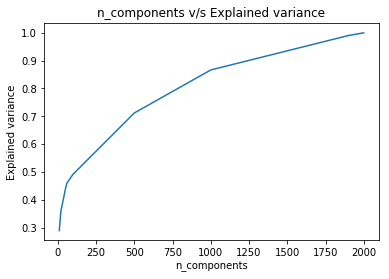

In [27]:
#plotting curve between n_components and explained variance
import matplotlib.pyplot as plt

plt.plot(n_components, explained_variance)
plt.xlabel('n_components')
plt.ylabel("Explained variance")
plt.title("n_components v/s Explained variance")
plt.show()

In [28]:

from sklearn.decomposition import TruncatedSVD

tsvd=TruncatedSVD(n_components=1600,random_state=42)
final_co_occurrence_matrix=tsvd.fit_transform(co_occurrence_matrix)

In [29]:
with open('final_coo_matrix.pickle', 'wb') as f:
    pickle.dump(final_co_occurrence_matrix, f)

In [30]:
final_co_occurrence_matrix.shape

(2000, 1600)

In [31]:
final_co_occurrence_matrix

array([[ 1.22260672e-14, -8.64717376e-15,  1.16445351e-14, ...,
        -3.84234992e-02,  1.83618894e-02,  8.63439431e-03],
       [-1.67255450e-15, -5.99916349e-17,  6.08709875e-16, ...,
         3.19238247e-17,  2.31392461e-17, -1.94817578e-19],
       [ 3.06843311e-16,  1.53320126e-14, -9.17663587e-15, ...,
        -2.38732846e-02, -3.11377183e-02, -8.83968529e-03],
       ...,
       [-9.62408097e-16,  9.37671672e-15, -6.29270298e-15, ...,
        -1.49539793e-02,  1.51040926e-02, -3.53548751e-02],
       [-1.25404001e-15,  2.60007186e-15,  1.08257205e-14, ...,
        -3.80156044e-02, -2.53252044e-03,  1.27461287e-02],
       [-1.41574036e-16,  2.63343547e-16, -2.30068978e-16, ...,
        -5.00133251e-18, -3.58936564e-17,  8.74796570e-17]])

In [35]:
model = {}
for i in range(len(IDF_list)):
    model[IDF_list[i]] = final_co_occurrence_matrix[i]

In [36]:
# model = final_2000_features
glove_words =  set(model.keys())

# Vectorizing Essay and Title using Avg W2V

In [57]:
with open('train_test_split_M11.pickle', 'rb') as f:
    X_train, X_test, y_train, y_test = pickle.load(f)

In [46]:
X_train.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'Date', 'project_subject_categories',
       'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'number', 'description',
       'price', 'quantity', 'clean_categories', 'clean_subcategories',
       'clean_teacher_prefix', 'clean_project_grade_category', 'clean_state',
       'clean_essays', 'sentiment_score_neg', 'sentiment_score_neu',
       'sentiment_score_pos', 'sentiment_score_compound', 'clean_essay_length',
       'clean_project_title', 'clean_title_length'],
      dtype='object')

In [47]:
X_test.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'Date', 'project_subject_categories',
       'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'number', 'description',
       'price', 'quantity', 'clean_categories', 'clean_subcategories',
       'clean_teacher_prefix', 'clean_project_grade_category', 'clean_state',
       'clean_essays', 'sentiment_score_neg', 'sentiment_score_neu',
       'sentiment_score_pos', 'sentiment_score_compound', 'clean_essay_length',
       'clean_project_title', 'clean_title_length'],
      dtype='object')

In [48]:
X_train_avg_w2v_titles_vectors = []; 
for sentence in tqdm(X_train['clean_project_title']):
    vector = np.zeros(1600)
    cnt_words =0;
    for word in sentence.split():
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    X_train_avg_w2v_titles_vectors.append(vector)

100%|██████████| 35000/35000 [00:00<00:00, 192400.53it/s]


In [49]:
X_train_avg_w2v_essays_vectors = [];
for sentence in tqdm(X_train['clean_essays']):
    vector = np.zeros(1600)
    cnt_words =0;
    for word in sentence.split():
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    X_train_avg_w2v_essays_vectors.append(vector)

100%|██████████| 35000/35000 [00:01<00:00, 29595.86it/s]


In [50]:
X_test_avg_w2v_titles_vectors = [];
for sentence in tqdm(X_test['clean_project_title']):
    vector = np.zeros(1600)
    cnt_words =0;
    for word in sentence.split():
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    X_test_avg_w2v_titles_vectors.append(vector)

100%|██████████| 15000/15000 [00:00<00:00, 80383.30it/s]


In [51]:
X_test_avg_w2v_essays_vectors = [];
for sentence in tqdm(X_test['clean_essays']):
    vector = np.zeros(1600)
    cnt_words =0;
    for word in sentence.split():
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    X_test_avg_w2v_essays_vectors.append(vector)

100%|██████████| 15000/15000 [00:00<00:00, 24031.27it/s]


# Calculating the Word Count of each Essay and Title in each train and test

In [53]:
title_wordcount_train = []
title_train = list(X_train['clean_project_title'])
for i in tqdm(title_train):
    b = len(str(i).split())
    title_wordcount_train.append(b)
title_wordcount_train = np.array(title_wordcount_train)

title_wordcount_test = []
title_test = list(X_test['clean_project_title'])
for i in tqdm(title_test):
    b = len(str(i).split())
    title_wordcount_test.append(b)
title_wordcount_test = np.array(title_wordcount_test)

print(title_wordcount_train.shape)
print(title_wordcount_test.shape)

100%|██████████| 15000/15000 [00:00<00:00, 855852.32it/s]

(35000,)
(15000,)


In [54]:
essay_wordcount_train = []
essay_train = list(X_train['clean_essays'])
for i in tqdm(essay_train):
    b = len(str(i).split())
    essay_wordcount_train.append(b)
essay_wordcount_train = np.array(essay_wordcount_train)


essay_wordcount_test = []
essay_test = list(X_test['clean_essays'])
for i in tqdm(essay_test):
    b = len(str(i).split())
    essay_wordcount_test.append(b)
essay_wordcount_test = np.array(essay_wordcount_test)

print(essay_wordcount_train.shape)
print(essay_wordcount_test.shape)

100%|██████████| 15000/15000 [00:00<00:00, 97766.74it/s]

(35000,)
(15000,)


# Standardizing Title and Essay Word Count

In [55]:
from sklearn.preprocessing import StandardScaler

title_wordcount_scalar = StandardScaler()
title_wordcount_scalar.fit(title_wordcount_train.reshape(-1,1))

X_train_title_wordcount_standardized = title_wordcount_scalar.transform(title_wordcount_train.reshape(-1,1))
X_test_title_wordcount_standardized = title_wordcount_scalar.transform(title_wordcount_test.reshape(-1,1))

print(title_wordcount_standardized_train.shape)
print(title_wordcount_standardized_test.shape)

(35000, 1)
(15000, 1)


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [56]:
essay_wordcount_scalar = StandardScaler()
essay_wordcount_scalar.fit(essay_wordcount_train.reshape(-1,1))

X_train_essay_wordcount_standardized = essay_wordcount_scalar.transform(essay_wordcount_train.reshape(-1,1))
X_test_essay_wordcount_standardized = essay_wordcount_scalar.transform(essay_wordcount_test.reshape(-1,1))

print(essay_wordcount_standardized_train.shape)
print(essay_wordcount_standardized_test.shape)

(35000, 1)
(15000, 1)


# Merging all together

In [74]:
from scipy.sparse import hstack

X_tr = hstack((X_train_state_ohe, \
               X_train_clean_categories_ohe, \
               X_train_clean_subcategories_ohe, \
               X_train_clean_project_grade_category_ohe, \
               X_train_clean_teacher_prefix_category_ohe, \
               X_train_price_norm, \
               X_train_teacher_number_of_previously_posted_projects_norm, \
               X_train_quantity_norm, \
               X_train_sentiment_score_neg_norm, \
               X_train_sentiment_score_neu_norm, \
               X_train_sentiment_score_pos_norm, \
               X_train_sentiment_score_compound_norm, \
               X_train_clean_title_length_norm, \
               X_train_clean_essay_length_norm, \
               X_train_title_wordcount_standardized, \
               X_train_essay_wordcount_standardized, \
               X_train_avg_w2v_titles_vectors, \
               X_train_avg_w2v_essays_vectors)).tocsr()

X_te = hstack((X_test_state_ohe, \
               X_test_clean_categories_ohe, \
               X_test_clean_subcategories_ohe, \
               X_test_clean_project_grade_category_ohe, \
               X_test_clean_teacher_prefix_category_ohe, \
               X_test_price_norm, \
               X_test_teacher_number_of_previously_posted_projects_norm, \
               X_test_quantity_norm, \
               X_test_sentiment_score_neg_norm, \
               X_test_sentiment_score_neu_norm, \
               X_test_sentiment_score_pos_norm, \
               X_test_sentiment_score_compound_norm, \
               X_test_clean_title_length_norm, \
               X_test_clean_essay_length_norm, \
               X_test_title_wordcount_standardized, \
               X_test_essay_wordcount_standardized, \
               X_test_avg_w2v_titles_vectors, \
               X_test_avg_w2v_essays_vectors)).tocsr()

In [75]:
print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(35000, 3678) (35000,)
(15000, 3678) (15000,)


# Applying XGBoost

In [2]:
from xgboost import XGBClassifier as xgbc
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

In [3]:
parlist_maxdepth_gbdt = [2, 3, 4, 5, 6, 7, 8, 9, 10]
parlist_n_estimators_gbdt = [5, 10, 50, 100, 200, 500, 1000]
parameters_gbdt = {'max_depth': parlist_maxdepth_gbdt, 'n_estimators': parlist_n_estimators_gbdt}
print(parameters_gbdt)

{'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10], 'n_estimators': [5, 10, 50, 100, 200, 500, 1000]}


## Hyperparameter Tuning on XGBoost

In [4]:
def hparameter_tuning_xgb(X_tr_data, y_train_data, filename):
    
    xgb = xgbc(n_jobs=-1)
    
    clf = GridSearchCV(estimator=xgb, param_grid=parameters_gbdt, cv=3, scoring='roc_auc', n_jobs=-1)
    clf.fit(X_tr_data, y_train_data)
    results = clf.cv_results_
    best_hyperparameter = clf.best_params_
    best_score = clf.best_score_
    best_estimator = clf.best_estimator_
    
    with open(filename, 'wb') as f:
        pickle.dump([results, best_hyperparameter, best_score, best_estimator] , f)

## AUC Results Function

In [14]:
def auc_score_plot(results):
    train_auc_mean_notreshaped = results['mean_train_score']
    cv_auc_mean_notreshaped = results['mean_test_score']
    train_auc_mean = np.reshape(train_auc_mean_notreshaped, (9, 7))
    cv_auc_mean = np.reshape(cv_auc_mean_notreshaped, (9, 7))
    fig, ax = plt.subplots(1,2,figsize=(20,12))
    ax[0].title.set_text('Mean Train Score')
    ax[1].title.set_text('Mean CV Score')
    sns.heatmap(train_auc_mean, cmap='YlGnBu', annot=True, fmt='g', linewidths=.5, xticklabels=[5, 10, 50, 100, 200, 500, 1000], \
                yticklabels=[2, 3, 4, 5, 6, 7, 8, 9, 10], ax=ax[0])
    sns.heatmap(cv_auc_mean, cmap='YlGnBu', annot=True, fmt='g', linewidths=.5, xticklabels=[5, 10, 50, 100, 200, 500, 1000], \
                yticklabels=[2, 3, 4, 5, 6, 7, 8, 9, 10], ax=ax[1])
    ax[0].set_ylabel('max_depth')
    ax[0].set_xlabel('n_estimators')
    ax[1].set_ylabel('max_depth')
    ax[1].set_xlabel('n_estimators')
    plt.show()

# XGBoost Classifier

In [6]:
# https://docs.scipy.org/doc/numpy-1.9.3/reference/generated/numpy.greater_equal.html
# https://stackoverflow.com/questions/15868512/list-to-array-conversion-to-use-ravel-function

def xgb_classifier(best_estimator, X_tr_data, y_train_data, X_test_data, y_test_data, filename):
    
    xgb = best_estimator
    fitted_tree = xgb.fit(X_tr_data, y_train_data)
    
    y_train_predict_proba = xgb.predict_proba(X_tr_data)
    y_test_predict_proba = xgb.predict_proba(X_test_data)
    
    train_fpr, train_tpr, tr_thresholds = roc_curve(y_train_data, y_train_predict_proba[:,1])
    test_fpr, test_tpr, te_thresholds = roc_curve(y_test_data, y_test_predict_proba[:,1])
    
    y_tr = tr_thresholds[np.argmax(train_fpr*(1-train_tpr))]
    y_train_predict = []
    for i in y_train_predict_proba[:,1]:
        if np.greater_equal(i, y_tr):
            y_train_predict.append(1)
        else:
            y_train_predict.append(0)
            
    y_te = tr_thresholds[np.argmax(test_fpr*(1-test_tpr))]
    y_test_predict = []
    for i in y_test_predict_proba[:,1]:
        if np.greater_equal(i, y_te):
            y_test_predict.append(1)
        else:
            y_test_predict.append(0)
    
    train_auc = auc(train_fpr, train_tpr)
    test_auc = auc(test_fpr, test_tpr)
    
    y_train_predict = np.asarray(y_train_predict)
    y_test_predict = np.asarray(y_test_predict)
    
    with open(filename, 'wb') as f:
        pickle.dump([train_fpr, train_tpr, train_auc, y_train_predict, test_fpr, test_tpr, test_auc, y_test_predict] , f)

## Plotting ROC Curve

In [7]:
def roc_plot(train_fpr, train_tpr, train_auc, test_fpr, test_tpr, test_auc):
    plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(train_auc))
    plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(test_auc))
    plt.legend()
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC PLOTS")
    plt.grid()
    plt.show()

## Predictions

## Train Confusion Matrix

In [8]:
# https://stackoverflow.com/questions/29647749/seaborn-showing-scientific-notation-in-heatmap-for-3-digit-numbers
def train_conf(y_train, y_train_predict):
    cm_train = confusion_matrix(y_train, y_train_predict.round())
    plt.title('Train actual & Train predicted Confusion matrix')
    xlabels= ['Actual Negative', 'Actual Positive']
    ylabels=['Predicted Negative', 'Predicted Positive']
    sns.heatmap(cm_train, cmap='YlGnBu', annot=True, fmt='g', linewidths=.5, xticklabels=xlabels, yticklabels=ylabels)
    plt.show()

## Test Confusion Matrix

In [9]:
# https://stackoverflow.com/questions/29647749/seaborn-showing-scientific-notation-in-heatmap-for-3-digit-numbers
def test_conf(y_test, y_test_predict):
    cm_test = confusion_matrix(y_test, y_test_predict.round())
    plt.title('Test actual & Test predicted Confusion matrix')
    xlabels= ['Actual Negative', 'Actual Positive']
    ylabels=['Predicted Negative', 'Predicted Positive']
    sns.heatmap(cm_test, cmap='YlGnBu', annot=True, fmt='g', linewidths=.5, xticklabels=xlabels, yticklabels=ylabels)
    plt.show()

# XGBoost Results

#### Hyperparameter tuning

In [10]:
hparameter_tuning_xgb(X_tr, y_train, 'grid_s_results.pickle')

#### Opening Grid Search result variables after Hyperparameter tuning

In [3]:
with open('grid_s_results.pickle', 'rb') as f:
    results, best_hyperparameter, best_score, best_estimator = pickle.load(f)

#### Results of Hyperparameter Tuning (Best Hyper parameters, Score)

In [13]:
import pickle
with open('grid_s_results.pickle', 'rb') as f:
    results, best_hyperparameter, best_score, best_estimator = pickle.load(f)

Best Hyperparameter: {'n_estimators': 200, 'max_depth': 2}
Best Score: 0.5863233191855802


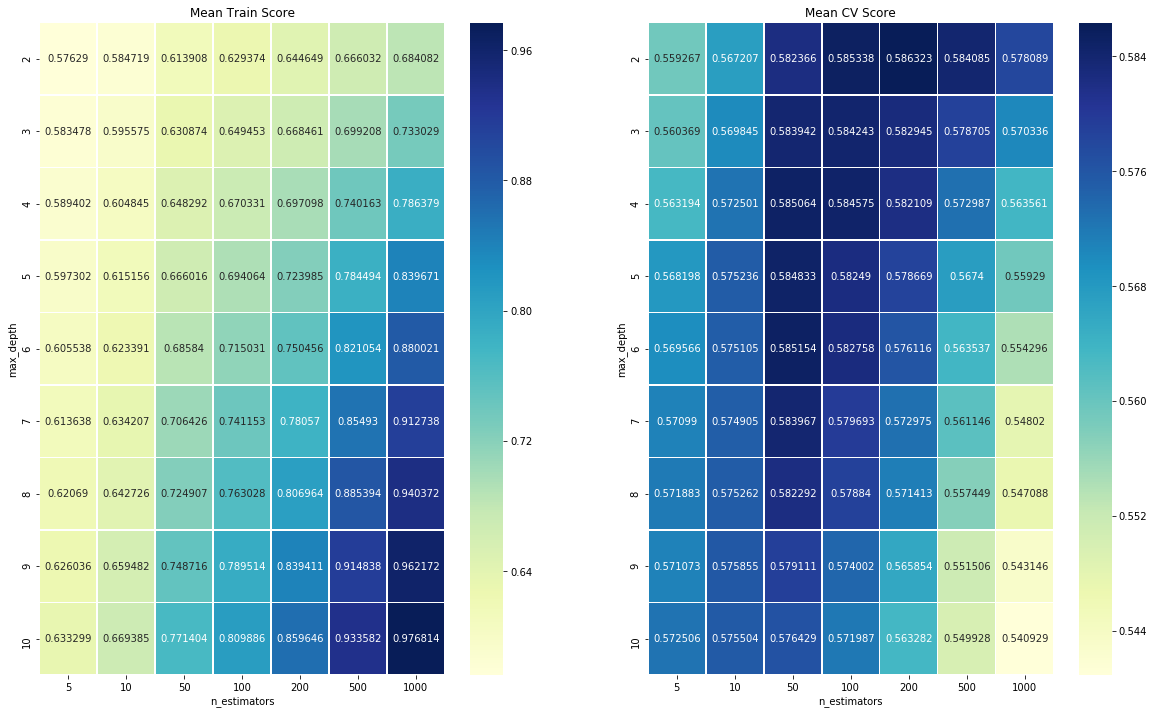

In [16]:
print("Best Hyperparameter: "+ str(best_hyperparameter))
print("Best Score: "+ str(best_score))
auc_score_plot(results)

#### Running Random Forest Classifier on best hyperparameters

In [16]:
xgb_classifier(best_estimator, X_tr, y_train, X_te, y_test, 'auc_score.pickle')

#### Opening Random Forest classifier results

In [17]:
# https://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

with open('auc_score.pickle', 'rb') as f:
    tr_fpr, tr_tpr, tr_auc, y_tr_predict, te_fpr, te_tpr, te_auc, y_te_predict = pickle.load(f)

#### Plotting ROC curve

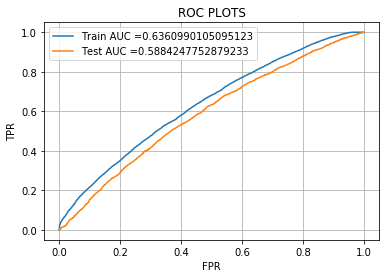

In [19]:
roc_plot(tr_fpr, tr_tpr, tr_auc, te_fpr, te_tpr, te_auc)

#### Train confusion matrix

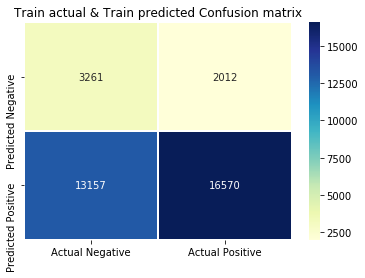

In [22]:
train_conf(y_train, y_tr_predict)

#### Test confusion matrix

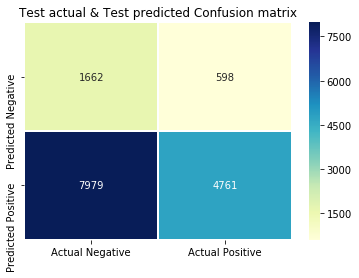

In [24]:
test_conf(y_test, y_te_predict)

# Summary

XGBoost results are as follows:
1. n_estimators = 200
2. max_depth = 2
3. Best Score = 0.586
4. Train AUC = 0.636
5. Test AUC = 0.588

These were the results of performing XGBoost Hyperparameter Tuning and Classification.

## Conclusion:

Although the Train AUC and Test AUC are not as good as the ones performed in previous assignments, these results could be improved significantly.